## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)

    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)

        
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 49591

endpointURL = "http://localhost:3030/REACTOME_GGALLUS/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,87968
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,31417
2,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,20670
3,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,20402
4,http://www.biopax.org/release/biopax-level3.owl#Protein,16984
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,14591
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,14591
7,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,8467
8,http://www.biopax.org/release/biopax-level3.owl#Evidence,8092
9,http://www.biopax.org/release/biopax-level3.owl#Complex,8046


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,435


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,7611


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3438


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4173


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,334


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,194


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3244


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,2746


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    8046.000000
mean        2.289461
std         2.765607
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

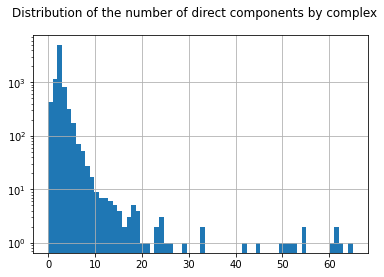

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

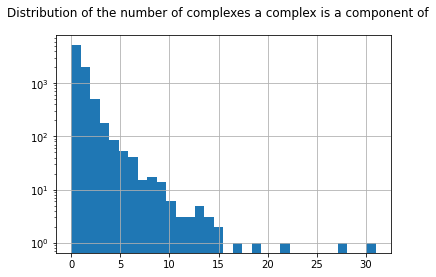

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,11062


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,4873


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,3839


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,5797


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,6210


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2,loc1
0,http://www.reactome.org/biopax/81/49591#Complex7238,http://www.reactome.org/biopax/81/49591#Complex7242,http://www.reactome.org/biopax/81/49591#CellularLocationVocabulary1
1,http://www.reactome.org/biopax/81/49591#Complex7331,http://www.reactome.org/biopax/81/49591#Complex7332,http://www.reactome.org/biopax/81/49591#CellularLocationVocabulary2


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

2

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [24]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes  <a class="anchor" id="function3"></a>

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [27]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.22981929779052734	http://www.reactome.org/biopax/81/49591#Complex10
1	0.5404560565948486	http://www.reactome.org/biopax/81/49591#Complex12
2	0.753633975982666	http://www.reactome.org/biopax/81/49591#Complex41
3	0.8589251041412354	http://www.reactome.org/biopax/81/49591#Complex54
4	1.775810718536377	http://www.reactome.org/biopax/81/49591#Complex69
5	2.979720115661621	http://www.reactome.org/biopax/81/49591#Complex55
6	3.578545570373535	http://www.reactome.org/biopax/81/49591#Complex56
7	4.0083067417144775	http://www.reactome.org/biopax/81/49591#Complex57
8	4.356351137161255	http://www.reactome.org/biopax/81/49591#Complex70
9	5.312736749649048	http://www.reactome.org/biopax/81/49591#Complex72
10	6.2304534912109375	http://www.reactome.org/biopax/81/49591#Complex73
11	6.937649488449097	http://www.reactome.org/biopax/81/49591#Complex74
12	7.489167213439941	http://www.reactome.org/biopax/81/49591#Complex76
13	7.6757190227508545	http://www.reactome.org/biopax/81/49591#Complex78
14	8.3037

114	66.15775847434998	http://www.reactome.org/biopax/81/49591#Complex298
115	66.37283062934875	http://www.reactome.org/biopax/81/49591#Complex302
116	66.48994612693787	http://www.reactome.org/biopax/81/49591#Complex303
117	67.15159749984741	http://www.reactome.org/biopax/81/49591#Complex306
118	67.98368811607361	http://www.reactome.org/biopax/81/49591#Complex308
119	68.45850872993469	http://www.reactome.org/biopax/81/49591#Complex310
120	68.97914028167725	http://www.reactome.org/biopax/81/49591#Complex311
121	69.27127075195312	http://www.reactome.org/biopax/81/49591#Complex312
122	69.547842502594	http://www.reactome.org/biopax/81/49591#Complex315
123	69.83487010002136	http://www.reactome.org/biopax/81/49591#Complex313
124	70.08603978157043	http://www.reactome.org/biopax/81/49591#Complex316
125	70.34892630577087	http://www.reactome.org/biopax/81/49591#Complex318
126	70.63553214073181	http://www.reactome.org/biopax/81/49591#Complex319
127	70.92749404907227	http://www.reactome.org/biopax/

226	294.1228218078613	http://www.reactome.org/biopax/81/49591#Complex509
227	294.8194589614868	http://www.reactome.org/biopax/81/49591#Complex515
228	295.498494386673	http://www.reactome.org/biopax/81/49591#Complex511
229	295.8102297782898	http://www.reactome.org/biopax/81/49591#Complex512
230	296.0416729450226	http://www.reactome.org/biopax/81/49591#Complex516
231	296.7823507785797	http://www.reactome.org/biopax/81/49591#Complex517
232	297.6399550437927	http://www.reactome.org/biopax/81/49591#Complex519
233	298.50005650520325	http://www.reactome.org/biopax/81/49591#Complex520
234	299.3223693370819	http://www.reactome.org/biopax/81/49591#Complex521
235	300.1104691028595	http://www.reactome.org/biopax/81/49591#Complex523
236	300.42548632621765	http://www.reactome.org/biopax/81/49591#Complex525
237	300.8742654323578	http://www.reactome.org/biopax/81/49591#Complex526
238	301.4241180419922	http://www.reactome.org/biopax/81/49591#Complex528
239	301.5407202243805	http://www.reactome.org/biop

339	385.27104353904724	http://www.reactome.org/biopax/81/49591#Complex849
340	385.38605976104736	http://www.reactome.org/biopax/81/49591#Complex850
341	385.4670445919037	http://www.reactome.org/biopax/81/49591#Complex852
342	385.6033890247345	http://www.reactome.org/biopax/81/49591#Complex874
343	385.8039309978485	http://www.reactome.org/biopax/81/49591#Complex876
344	385.998158454895	http://www.reactome.org/biopax/81/49591#Complex877
345	386.17413544654846	http://www.reactome.org/biopax/81/49591#Complex878
346	386.34440565109253	http://www.reactome.org/biopax/81/49591#Complex932
347	386.43025040626526	http://www.reactome.org/biopax/81/49591#Complex941
348	386.51954793930054	http://www.reactome.org/biopax/81/49591#Complex943
349	386.623464345932	http://www.reactome.org/biopax/81/49591#Complex952
350	386.78251576423645	http://www.reactome.org/biopax/81/49591#Complex954
351	387.04761242866516	http://www.reactome.org/biopax/81/49591#Complex1000
352	387.13122844696045	http://www.reactome.o

451	433.44085001945496	http://www.reactome.org/biopax/81/49591#Complex1516
452	433.54282879829407	http://www.reactome.org/biopax/81/49591#Complex1517
453	433.7208135128021	http://www.reactome.org/biopax/81/49591#Complex1520
454	433.9588510990143	http://www.reactome.org/biopax/81/49591#Complex1521
455	434.1799647808075	http://www.reactome.org/biopax/81/49591#Complex1523
456	434.4059865474701	http://www.reactome.org/biopax/81/49591#Complex1526
457	434.4829833507538	http://www.reactome.org/biopax/81/49591#Complex1528
458	434.55754947662354	http://www.reactome.org/biopax/81/49591#Complex1549
459	434.63140773773193	http://www.reactome.org/biopax/81/49591#Complex1559
460	434.7174756526947	http://www.reactome.org/biopax/81/49591#Complex1565
461	435.0229866504669	http://www.reactome.org/biopax/81/49591#Complex1567
462	435.3417589664459	http://www.reactome.org/biopax/81/49591#Complex1568
463	435.65701365470886	http://www.reactome.org/biopax/81/49591#Complex1574
464	435.76330852508545	http://www

563	463.2151849269867	http://www.reactome.org/biopax/81/49591#Complex2035
564	463.32768630981445	http://www.reactome.org/biopax/81/49591#Complex2036
565	463.4322965145111	http://www.reactome.org/biopax/81/49591#Complex2038
566	463.8664128780365	http://www.reactome.org/biopax/81/49591#Complex2043
567	464.53198194503784	http://www.reactome.org/biopax/81/49591#Complex2039
568	464.6953582763672	http://www.reactome.org/biopax/81/49591#Complex2040
569	464.81692695617676	http://www.reactome.org/biopax/81/49591#Complex2041
570	464.9859573841095	http://www.reactome.org/biopax/81/49591#Complex2044
571	465.47246503829956	http://www.reactome.org/biopax/81/49591#Complex2045
572	465.6128911972046	http://www.reactome.org/biopax/81/49591#Complex2047
573	465.69424986839294	http://www.reactome.org/biopax/81/49591#Complex2065
574	466.2560019493103	http://www.reactome.org/biopax/81/49591#Complex2068
575	467.0199785232544	http://www.reactome.org/biopax/81/49591#Complex2075
576	467.2581136226654	http://www.

675	513.2721228599548	http://www.reactome.org/biopax/81/49591#Complex2347
676	513.450847864151	http://www.reactome.org/biopax/81/49591#Complex2348
677	513.63250041008	http://www.reactome.org/biopax/81/49591#Complex2349
678	513.77205991745	http://www.reactome.org/biopax/81/49591#Complex2350
679	513.8569815158844	http://www.reactome.org/biopax/81/49591#Complex2353
680	513.9858553409576	http://www.reactome.org/biopax/81/49591#Complex2356
681	514.166520357132	http://www.reactome.org/biopax/81/49591#Complex2357
682	514.2821249961853	http://www.reactome.org/biopax/81/49591#Complex2358
683	514.4040825366974	http://www.reactome.org/biopax/81/49591#Complex2359
684	514.6444308757782	http://www.reactome.org/biopax/81/49591#Complex2361
685	514.9595341682434	http://www.reactome.org/biopax/81/49591#Complex2364
686	515.0937416553497	http://www.reactome.org/biopax/81/49591#Complex2369
687	515.1742498874664	http://www.reactome.org/biopax/81/49591#Complex2371
688	515.4184384346008	http://www.reactome.or

787	536.8596737384796	http://www.reactome.org/biopax/81/49591#Complex2615
788	536.9368758201599	http://www.reactome.org/biopax/81/49591#Complex2618
789	537.0829923152924	http://www.reactome.org/biopax/81/49591#Complex2619
790	537.1826894283295	http://www.reactome.org/biopax/81/49591#Complex2620
791	537.3329737186432	http://www.reactome.org/biopax/81/49591#Complex2623
792	537.4322929382324	http://www.reactome.org/biopax/81/49591#Complex2624
793	537.5467700958252	http://www.reactome.org/biopax/81/49591#Complex2627
794	537.6684753894806	http://www.reactome.org/biopax/81/49591#Complex2628
795	537.7925455570221	http://www.reactome.org/biopax/81/49591#Complex2635
796	537.8875231742859	http://www.reactome.org/biopax/81/49591#Complex2638
797	538.0552065372467	http://www.reactome.org/biopax/81/49591#Complex2639
798	538.3079259395599	http://www.reactome.org/biopax/81/49591#Complex2645
799	538.4347198009491	http://www.reactome.org/biopax/81/49591#Complex2646
800	538.554137468338	http://www.reacto

898	553.6152412891388	http://www.reactome.org/biopax/81/49591#Complex2993
899	553.8597095012665	http://www.reactome.org/biopax/81/49591#Complex2994
900	554.0068321228027	http://www.reactome.org/biopax/81/49591#Complex2995
901	554.2001988887787	http://www.reactome.org/biopax/81/49591#Complex2998
902	554.4872069358826	http://www.reactome.org/biopax/81/49591#Complex2999
903	554.6816022396088	http://www.reactome.org/biopax/81/49591#Complex3000
904	554.9426023960114	http://www.reactome.org/biopax/81/49591#Complex3008
905	555.2926461696625	http://www.reactome.org/biopax/81/49591#Complex3010
906	555.5772285461426	http://www.reactome.org/biopax/81/49591#Complex3012
907	555.78346991539	http://www.reactome.org/biopax/81/49591#Complex3015
908	555.992045879364	http://www.reactome.org/biopax/81/49591#Complex3016
909	556.1858768463135	http://www.reactome.org/biopax/81/49591#Complex3020
910	556.5029494762421	http://www.reactome.org/biopax/81/49591#Complex3021
911	556.7983345985413	http://www.reactome

1010	580.0361278057098	http://www.reactome.org/biopax/81/49591#Complex3270
1011	580.2365517616272	http://www.reactome.org/biopax/81/49591#Complex3272
1012	580.4923367500305	http://www.reactome.org/biopax/81/49591#Complex3273
1013	580.6441938877106	http://www.reactome.org/biopax/81/49591#Complex3276
1014	580.8132853507996	http://www.reactome.org/biopax/81/49591#Complex3277
1015	580.991730928421	http://www.reactome.org/biopax/81/49591#Complex3281
1016	581.1954834461212	http://www.reactome.org/biopax/81/49591#Complex3286
1017	581.3077936172485	http://www.reactome.org/biopax/81/49591#Complex3288
1018	581.4680891036987	http://www.reactome.org/biopax/81/49591#Complex3289
1019	581.620199918747	http://www.reactome.org/biopax/81/49591#Complex3290
1020	581.7343237400055	http://www.reactome.org/biopax/81/49591#Complex3292
1021	581.852236032486	http://www.reactome.org/biopax/81/49591#Complex3294
1022	581.962296962738	http://www.reactome.org/biopax/81/49591#Complex3296
1023	582.0725915431976	http:/

1120	804.0986225605011	http://www.reactome.org/biopax/81/49591#Complex3485
1121	813.0379927158356	http://www.reactome.org/biopax/81/49591#Complex3488
1122	813.3024730682373	http://www.reactome.org/biopax/81/49591#Complex3490
1123	813.4788961410522	http://www.reactome.org/biopax/81/49591#Complex3493
1124	826.2436692714691	http://www.reactome.org/biopax/81/49591#Complex3494
1125	826.9054818153381	http://www.reactome.org/biopax/81/49591#Complex3495
1126	837.3822944164276	http://www.reactome.org/biopax/81/49591#Complex3497
1127	848.0781986713409	http://www.reactome.org/biopax/81/49591#Complex3496
1128	848.2746489048004	http://www.reactome.org/biopax/81/49591#Complex3498
1129	852.3774712085724	http://www.reactome.org/biopax/81/49591#Complex3506
1130	856.0351314544678	http://www.reactome.org/biopax/81/49591#Complex3499
1131	859.867778301239	http://www.reactome.org/biopax/81/49591#Complex3507
1132	863.3818473815918	http://www.reactome.org/biopax/81/49591#Complex3508
1133	867.1961185932159	htt

1230	894.4383051395416	http://www.reactome.org/biopax/81/49591#Complex3724
1231	894.5467548370361	http://www.reactome.org/biopax/81/49591#Complex3729
1232	894.7190282344818	http://www.reactome.org/biopax/81/49591#Complex3730
1233	894.8806810379028	http://www.reactome.org/biopax/81/49591#Complex3731
1234	894.9887156486511	http://www.reactome.org/biopax/81/49591#Complex3732
1235	895.0869197845459	http://www.reactome.org/biopax/81/49591#Complex3733
1236	895.1841433048248	http://www.reactome.org/biopax/81/49591#Complex3735
1237	895.3295760154724	http://www.reactome.org/biopax/81/49591#Complex3736
1238	895.5256140232086	http://www.reactome.org/biopax/81/49591#Complex3740
1239	895.6385290622711	http://www.reactome.org/biopax/81/49591#Complex3742
1240	895.8515684604645	http://www.reactome.org/biopax/81/49591#Complex3743
1241	896.4478499889374	http://www.reactome.org/biopax/81/49591#Complex3744
1242	897.0100240707397	http://www.reactome.org/biopax/81/49591#Complex3745
1243	897.4568543434143	ht

1340	916.6650574207306	http://www.reactome.org/biopax/81/49591#Complex4023
1341	917.0589530467987	http://www.reactome.org/biopax/81/49591#Complex4025
1342	917.4607586860657	http://www.reactome.org/biopax/81/49591#Complex4026
1343	917.5389950275421	http://www.reactome.org/biopax/81/49591#Complex4028
1344	917.9607501029968	http://www.reactome.org/biopax/81/49591#Complex4029
1345	918.0532505512238	http://www.reactome.org/biopax/81/49591#Complex4031
1346	918.1352248191833	http://www.reactome.org/biopax/81/49591#Complex4033
1347	918.6238958835602	http://www.reactome.org/biopax/81/49591#Complex4034
1348	919.1862649917603	http://www.reactome.org/biopax/81/49591#Complex4035
1349	919.3098177909851	http://www.reactome.org/biopax/81/49591#Complex4037
1350	919.4438393115997	http://www.reactome.org/biopax/81/49591#Complex4039
1351	919.5976102352142	http://www.reactome.org/biopax/81/49591#Complex4044
1352	919.7063744068146	http://www.reactome.org/biopax/81/49591#Complex4049
1353	919.8959314823151	ht

1451	939.4282088279724	http://www.reactome.org/biopax/81/49591#Complex4260
1452	939.5888426303864	http://www.reactome.org/biopax/81/49591#Complex4261
1453	939.6987228393555	http://www.reactome.org/biopax/81/49591#Complex4263
1454	939.8473007678986	http://www.reactome.org/biopax/81/49591#Complex4264
1455	939.9922008514404	http://www.reactome.org/biopax/81/49591#Complex4266
1456	940.145566701889	http://www.reactome.org/biopax/81/49591#Complex4267
1457	940.344803571701	http://www.reactome.org/biopax/81/49591#Complex4301
1458	940.4653046131134	http://www.reactome.org/biopax/81/49591#Complex4302
1459	940.5924258232117	http://www.reactome.org/biopax/81/49591#Complex4304
1460	940.7157561779022	http://www.reactome.org/biopax/81/49591#Complex4305
1461	940.840580701828	http://www.reactome.org/biopax/81/49591#Complex4307
1462	941.0130529403687	http://www.reactome.org/biopax/81/49591#Complex4308
1463	941.1529548168182	http://www.reactome.org/biopax/81/49591#Complex4310
1464	941.2899436950684	http:

1562	961.1328291893005	http://www.reactome.org/biopax/81/49591#Complex4463
1563	961.2743561267853	http://www.reactome.org/biopax/81/49591#Complex4465
1564	961.4470224380493	http://www.reactome.org/biopax/81/49591#Complex4467
1565	961.6250355243683	http://www.reactome.org/biopax/81/49591#Complex4469
1566	961.7928898334503	http://www.reactome.org/biopax/81/49591#Complex4471
1567	961.9535937309265	http://www.reactome.org/biopax/81/49591#Complex4472
1568	962.1037480831146	http://www.reactome.org/biopax/81/49591#Complex4474
1569	962.2623775005341	http://www.reactome.org/biopax/81/49591#Complex4475
1570	962.4420804977417	http://www.reactome.org/biopax/81/49591#Complex4476
1571	962.6137003898621	http://www.reactome.org/biopax/81/49591#Complex4477
1572	962.7794172763824	http://www.reactome.org/biopax/81/49591#Complex4480
1573	962.938291311264	http://www.reactome.org/biopax/81/49591#Complex4482
1574	963.107724905014	http://www.reactome.org/biopax/81/49591#Complex4484
1575	963.2540411949158	http

1674	980.4761235713959	http://www.reactome.org/biopax/81/49591#Complex4669
1675	980.57861495018	http://www.reactome.org/biopax/81/49591#Complex4670
1676	980.6580324172974	http://www.reactome.org/biopax/81/49591#Complex4676
1677	980.7681472301483	http://www.reactome.org/biopax/81/49591#Complex4683
1678	980.8552484512329	http://www.reactome.org/biopax/81/49591#Complex4685
1679	980.9492788314819	http://www.reactome.org/biopax/81/49591#Complex4688
1680	981.0663070678711	http://www.reactome.org/biopax/81/49591#Complex4690
1681	981.1910026073456	http://www.reactome.org/biopax/81/49591#Complex4692
1682	981.3742561340332	http://www.reactome.org/biopax/81/49591#Complex4693
1683	981.5502526760101	http://www.reactome.org/biopax/81/49591#Complex4694
1684	981.6931858062744	http://www.reactome.org/biopax/81/49591#Complex4695
1685	981.847959280014	http://www.reactome.org/biopax/81/49591#Complex4696
1686	982.0014796257019	http://www.reactome.org/biopax/81/49591#Complex4697
1687	982.2071959972382	http:

1784	1002.1220333576202	http://www.reactome.org/biopax/81/49591#Complex5081
1785	1002.2676799297333	http://www.reactome.org/biopax/81/49591#Complex5085
1786	1002.4160723686218	http://www.reactome.org/biopax/81/49591#Complex5086
1787	1002.6165506839752	http://www.reactome.org/biopax/81/49591#Complex5087
1788	1002.8624382019043	http://www.reactome.org/biopax/81/49591#Complex5088
1789	1003.1058983802795	http://www.reactome.org/biopax/81/49591#Complex5097
1790	1003.2173976898193	http://www.reactome.org/biopax/81/49591#Complex5101
1791	1003.3653807640076	http://www.reactome.org/biopax/81/49591#Complex5102
1792	1003.5892879962921	http://www.reactome.org/biopax/81/49591#Complex5106
1793	1003.7626159191132	http://www.reactome.org/biopax/81/49591#Complex5108
1794	1003.9697301387787	http://www.reactome.org/biopax/81/49591#Complex5109
1795	1004.1782858371735	http://www.reactome.org/biopax/81/49591#Complex5114
1796	1004.316116809845	http://www.reactome.org/biopax/81/49591#Complex5119
1797	1004.502

1892	1028.3712480068207	http://www.reactome.org/biopax/81/49591#Complex5335
1893	1028.5152230262756	http://www.reactome.org/biopax/81/49591#Complex5337
1894	1028.656048297882	http://www.reactome.org/biopax/81/49591#Complex5340
1895	1028.7554287910461	http://www.reactome.org/biopax/81/49591#Complex5343
1896	1028.9429063796997	http://www.reactome.org/biopax/81/49591#Complex5344
1897	1029.0650696754456	http://www.reactome.org/biopax/81/49591#Complex5345
1898	1029.230625629425	http://www.reactome.org/biopax/81/49591#Complex5348
1899	1029.9070575237274	http://www.reactome.org/biopax/81/49591#Complex5352
1900	1030.0283374786377	http://www.reactome.org/biopax/81/49591#Complex5368
1901	1030.1962132453918	http://www.reactome.org/biopax/81/49591#Complex5346
1902	1030.3234593868256	http://www.reactome.org/biopax/81/49591#Complex5354
1903	1030.5407514572144	http://www.reactome.org/biopax/81/49591#Complex5359
1904	1030.802725315094	http://www.reactome.org/biopax/81/49591#Complex5363
1905	1031.04223

2001	1052.2987377643585	http://www.reactome.org/biopax/81/49591#Complex5579
2002	1052.4218876361847	http://www.reactome.org/biopax/81/49591#Complex5582
2003	1052.7556874752045	http://www.reactome.org/biopax/81/49591#Complex5583
2004	1053.0333347320557	http://www.reactome.org/biopax/81/49591#Complex5584
2005	1053.4649996757507	http://www.reactome.org/biopax/81/49591#Complex5586
2006	1053.8703570365906	http://www.reactome.org/biopax/81/49591#Complex5588
2007	1054.3714790344238	http://www.reactome.org/biopax/81/49591#Complex5590
2008	1054.974731683731	http://www.reactome.org/biopax/81/49591#Complex5591
2009	1055.6042442321777	http://www.reactome.org/biopax/81/49591#Complex5593
2010	1056.1382665634155	http://www.reactome.org/biopax/81/49591#Complex5594
2011	1056.4247782230377	http://www.reactome.org/biopax/81/49591#Complex5597
2012	1056.7749192714691	http://www.reactome.org/biopax/81/49591#Complex5595
2013	1056.908038854599	http://www.reactome.org/biopax/81/49591#Complex5596
2014	1057.0373

2110	1235.5953500270844	http://www.reactome.org/biopax/81/49591#Complex5821
2111	1235.6900022029877	http://www.reactome.org/biopax/81/49591#Complex5823
2112	1235.795859336853	http://www.reactome.org/biopax/81/49591#Complex5828
2113	1235.9046273231506	http://www.reactome.org/biopax/81/49591#Complex5830
2114	1236.0310707092285	http://www.reactome.org/biopax/81/49591#Complex5833
2115	1236.8443217277527	http://www.reactome.org/biopax/81/49591#Complex5843
2116	1236.9900531768799	http://www.reactome.org/biopax/81/49591#Complex5845
2117	1237.133309841156	http://www.reactome.org/biopax/81/49591#Complex5853
2118	1237.293677330017	http://www.reactome.org/biopax/81/49591#Complex5855
2119	1237.4402770996094	http://www.reactome.org/biopax/81/49591#Complex5858
2120	1237.583769083023	http://www.reactome.org/biopax/81/49591#Complex5866
2121	1237.7215337753296	http://www.reactome.org/biopax/81/49591#Complex5882
2122	1237.8949904441833	http://www.reactome.org/biopax/81/49591#Complex5884
2123	1238.094186

2219	1263.1722030639648	http://www.reactome.org/biopax/81/49591#Complex6123
2220	1263.351092338562	http://www.reactome.org/biopax/81/49591#Complex6117
2221	1263.496071100235	http://www.reactome.org/biopax/81/49591#Complex6121
2222	1263.6469576358795	http://www.reactome.org/biopax/81/49591#Complex6124
2223	1263.8241755962372	http://www.reactome.org/biopax/81/49591#Complex6126
2224	1264.0659353733063	http://www.reactome.org/biopax/81/49591#Complex6127
2225	1264.3046226501465	http://www.reactome.org/biopax/81/49591#Complex6128
2226	1264.5807673931122	http://www.reactome.org/biopax/81/49591#Complex6129
2227	1264.8019545078278	http://www.reactome.org/biopax/81/49591#Complex6131
2228	1265.2567620277405	http://www.reactome.org/biopax/81/49591#Complex6133
2229	1265.941013097763	http://www.reactome.org/biopax/81/49591#Complex6136
2230	1266.7140736579895	http://www.reactome.org/biopax/81/49591#Complex6138
2231	1266.8470730781555	http://www.reactome.org/biopax/81/49591#Complex6139
2232	1267.61499

2329	1290.6647131443024	http://www.reactome.org/biopax/81/49591#Complex6352
2330	1290.9833703041077	http://www.reactome.org/biopax/81/49591#Complex6350
2331	1291.0549805164337	http://www.reactome.org/biopax/81/49591#Complex6353
2332	1291.264839887619	http://www.reactome.org/biopax/81/49591#Complex6356
2333	1291.6443512439728	http://www.reactome.org/biopax/81/49591#Complex6354
2334	1291.7186188697815	http://www.reactome.org/biopax/81/49591#Complex6357
2335	1291.8965983390808	http://www.reactome.org/biopax/81/49591#Complex6360
2336	1292.1788966655731	http://www.reactome.org/biopax/81/49591#Complex6358
2337	1292.2516431808472	http://www.reactome.org/biopax/81/49591#Complex6361
2338	1292.4619483947754	http://www.reactome.org/biopax/81/49591#Complex6363
2339	1292.793832540512	http://www.reactome.org/biopax/81/49591#Complex6366
2340	1293.1505358219147	http://www.reactome.org/biopax/81/49591#Complex6369
2341	1293.4846801757812	http://www.reactome.org/biopax/81/49591#Complex6370
2342	1293.8446

2438	1319.9458179473877	http://www.reactome.org/biopax/81/49591#Complex6543
2439	1320.4209768772125	http://www.reactome.org/biopax/81/49591#Complex6544
2440	1320.7690348625183	http://www.reactome.org/biopax/81/49591#Complex6545
2441	1321.1254024505615	http://www.reactome.org/biopax/81/49591#Complex6546
2442	1321.390920639038	http://www.reactome.org/biopax/81/49591#Complex6550
2443	1321.6231293678284	http://www.reactome.org/biopax/81/49591#Complex6548
2444	1321.7748560905457	http://www.reactome.org/biopax/81/49591#Complex6552
2445	1322.1551022529602	http://www.reactome.org/biopax/81/49591#Complex6553
2446	1322.3881967067719	http://www.reactome.org/biopax/81/49591#Complex6554
2447	1322.5346727371216	http://www.reactome.org/biopax/81/49591#Complex6556
2448	1322.8401424884796	http://www.reactome.org/biopax/81/49591#Complex6558
2449	1323.1139874458313	http://www.reactome.org/biopax/81/49591#Complex6560
2450	1323.518738269806	http://www.reactome.org/biopax/81/49591#Complex6561
2451	1323.6924

2547	1343.682974100113	http://www.reactome.org/biopax/81/49591#Complex6732
2548	1344.0400574207306	http://www.reactome.org/biopax/81/49591#Complex6735
2549	1344.170408964157	http://www.reactome.org/biopax/81/49591#Complex6740
2550	1344.3033282756805	http://www.reactome.org/biopax/81/49591#Complex6746
2551	1344.5114443302155	http://www.reactome.org/biopax/81/49591#Complex6748
2552	1344.7243909835815	http://www.reactome.org/biopax/81/49591#Complex6750
2553	1344.923279285431	http://www.reactome.org/biopax/81/49591#Complex6752
2554	1345.1791429519653	http://www.reactome.org/biopax/81/49591#Complex6753
2555	1345.4363157749176	http://www.reactome.org/biopax/81/49591#Complex6760
2556	1345.8021914958954	http://www.reactome.org/biopax/81/49591#Complex6764
2557	1346.2025620937347	http://www.reactome.org/biopax/81/49591#Complex6761
2558	1346.497436285019	http://www.reactome.org/biopax/81/49591#Complex6762
2559	1346.7454226016998	http://www.reactome.org/biopax/81/49591#Complex6766
2560	1346.866417

2656	1370.2213759422302	http://www.reactome.org/biopax/81/49591#Complex6944
2657	1370.6197946071625	http://www.reactome.org/biopax/81/49591#Complex6950
2658	1371.0578393936157	http://www.reactome.org/biopax/81/49591#Complex6955
2659	1371.4577927589417	http://www.reactome.org/biopax/81/49591#Complex6951
2660	1371.750591993332	http://www.reactome.org/biopax/81/49591#Complex6952
2661	1372.0307700634003	http://www.reactome.org/biopax/81/49591#Complex6959
2662	1372.1757650375366	http://www.reactome.org/biopax/81/49591#Complex6960
2663	1372.3498587608337	http://www.reactome.org/biopax/81/49591#Complex6961
2664	1372.5073668956757	http://www.reactome.org/biopax/81/49591#Complex6963
2665	1372.7195191383362	http://www.reactome.org/biopax/81/49591#Complex6964
2666	1372.9260597229004	http://www.reactome.org/biopax/81/49591#Complex6965
2667	1373.124088525772	http://www.reactome.org/biopax/81/49591#Complex6966
2668	1373.330356836319	http://www.reactome.org/biopax/81/49591#Complex6967
2669	1373.54490

2766	1392.7773089408875	http://www.reactome.org/biopax/81/49591#Complex7153
2767	1393.0072617530823	http://www.reactome.org/biopax/81/49591#Complex7155
2768	1393.3093020915985	http://www.reactome.org/biopax/81/49591#Complex7159
2769	1393.4581441879272	http://www.reactome.org/biopax/81/49591#Complex7160
2770	1393.6124653816223	http://www.reactome.org/biopax/81/49591#Complex7161
2771	1393.7780449390411	http://www.reactome.org/biopax/81/49591#Complex7164
2772	1394.085087776184	http://www.reactome.org/biopax/81/49591#Complex7170
2773	1394.1393954753876	http://www.reactome.org/biopax/81/49591#Complex7178
2774	1394.2279257774353	http://www.reactome.org/biopax/81/49591#Complex7180
2775	1394.3171548843384	http://www.reactome.org/biopax/81/49591#Complex7195
2776	1394.429928779602	http://www.reactome.org/biopax/81/49591#Complex7196
2777	1394.603628396988	http://www.reactome.org/biopax/81/49591#Complex7197
2778	1394.7462248802185	http://www.reactome.org/biopax/81/49591#Complex7198
2779	1394.88896

2875	1413.7697458267212	http://www.reactome.org/biopax/81/49591#Complex7401
2876	1413.9499354362488	http://www.reactome.org/biopax/81/49591#Complex7405
2877	1414.136901140213	http://www.reactome.org/biopax/81/49591#Complex7407
2878	1414.3050661087036	http://www.reactome.org/biopax/81/49591#Complex7448
2879	1414.7652118206024	http://www.reactome.org/biopax/81/49591#Complex7451
2880	1415.3675782680511	http://www.reactome.org/biopax/81/49591#Complex7449
2881	1415.7721824645996	http://www.reactome.org/biopax/81/49591#Complex7452
2882	1416.3790035247803	http://www.reactome.org/biopax/81/49591#Complex7453
2883	1416.8448631763458	http://www.reactome.org/biopax/81/49591#Complex7455
2884	1417.4312291145325	http://www.reactome.org/biopax/81/49591#Complex7456
2885	1417.850266456604	http://www.reactome.org/biopax/81/49591#Complex7457
2886	1418.435438156128	http://www.reactome.org/biopax/81/49591#Complex7458
2887	1419.0188746452332	http://www.reactome.org/biopax/81/49591#Complex7459
2888	1419.57499

2984	1477.5675973892212	http://www.reactome.org/biopax/81/49591#Complex7595
2985	1478.594307899475	http://www.reactome.org/biopax/81/49591#Complex7598
2986	1480.1582822799683	http://www.reactome.org/biopax/81/49591#Complex7599
2987	1482.4801359176636	http://www.reactome.org/biopax/81/49591#Complex7600
2988	1484.553104877472	http://www.reactome.org/biopax/81/49591#Complex7601
2989	1486.5103476047516	http://www.reactome.org/biopax/81/49591#Complex7602
2990	1488.0159230232239	http://www.reactome.org/biopax/81/49591#Complex7603
2991	1488.6105780601501	http://www.reactome.org/biopax/81/49591#Complex7604
2992	1489.0958099365234	http://www.reactome.org/biopax/81/49591#Complex7605
2993	1489.3425986766815	http://www.reactome.org/biopax/81/49591#Complex7606
2994	1489.5122385025024	http://www.reactome.org/biopax/81/49591#Complex7607
2995	1489.7316796779633	http://www.reactome.org/biopax/81/49591#Complex7608
2996	1489.9770021438599	http://www.reactome.org/biopax/81/49591#Complex7609
2997	1490.1550

3093	1578.3240325450897	http://www.reactome.org/biopax/81/49591#Complex7746
3094	1578.5979778766632	http://www.reactome.org/biopax/81/49591#Complex7747
3095	1579.0414998531342	http://www.reactome.org/biopax/81/49591#Complex7751
3096	1579.564299106598	http://www.reactome.org/biopax/81/49591#Complex7752
3097	1581.2485656738281	http://www.reactome.org/biopax/81/49591#Complex7753
3098	1582.8748874664307	http://www.reactome.org/biopax/81/49591#Complex7754
3099	1583.069232225418	http://www.reactome.org/biopax/81/49591#Complex7755
3100	1583.2324132919312	http://www.reactome.org/biopax/81/49591#Complex7757
3101	1584.9671783447266	http://www.reactome.org/biopax/81/49591#Complex7758
3102	1586.721364736557	http://www.reactome.org/biopax/81/49591#Complex7771
3103	1586.8236572742462	http://www.reactome.org/biopax/81/49591#Complex7772
3104	1586.9976694583893	http://www.reactome.org/biopax/81/49591#Complex7782
3105	1587.070727109909	http://www.reactome.org/biopax/81/49591#Complex7783
3106	1587.473775

3202	1685.459486246109	http://www.reactome.org/biopax/81/49591#Complex7954
3203	1686.0075957775116	http://www.reactome.org/biopax/81/49591#Complex7955
3204	1691.5851571559906	http://www.reactome.org/biopax/81/49591#Complex7959
3205	1696.8201005458832	http://www.reactome.org/biopax/81/49591#Complex7956
3206	1699.3643295764923	http://www.reactome.org/biopax/81/49591#Complex7961
3207	1701.6490259170532	http://www.reactome.org/biopax/81/49591#Complex7963
3208	1709.1194908618927	http://www.reactome.org/biopax/81/49591#Complex7965
3209	1715.154757976532	http://www.reactome.org/biopax/81/49591#Complex7966
3210	1715.4075319766998	http://www.reactome.org/biopax/81/49591#Complex7964
3211	1715.6888372898102	http://www.reactome.org/biopax/81/49591#Complex7970
3212	1716.0434637069702	http://www.reactome.org/biopax/81/49591#Complex7972
3213	1716.6086869239807	http://www.reactome.org/biopax/81/49591#Complex7973
3214	1717.4757270812988	http://www.reactome.org/biopax/81/49591#Complex7977
3215	1719.1541

In [28]:
# concat files
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [29]:
# ..\..\Downloads\apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-complexes-invalid-fixed.ttl

In [30]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 303.17689633369446


In [31]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_GGALLUS/update
Duration: 676.7127213478088


### (Merge files before identify and quantify redundant complexes)